In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import re


In [2]:
# Load the dataset
df = pd.read_csv('scaler_clustering.csv')

# Display the first few rows of the dataset
print(df.head())

# Check the structure and characteristics of the dataset
print(df.info())
print(df.describe())

   Unnamed: 0               company_hash  \
0           0             atrgxnnt xzaxv   
1           1  qtrxvzwt xzegwgbb rxbxnta   
2           2              ojzwnvwnxw vx   
3           3                  ngpgutaxv   
4           4                 qxen sqghu   

                                          email_hash  orgyear      ctc  \
0  6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...   2016.0  1100000   
1  b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...   2018.0   449999   
2  4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...   2015.0  2000000   
3  effdede7a2e7c2af664c8a31d9346385016128d66bbc58...   2017.0   700000   
4  6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...   2017.0  1400000   

         job_position  ctc_updated_year  
0               Other            2020.0  
1  FullStack Engineer            2019.0  
2    Backend Engineer            2020.0  
3    Backend Engineer            2019.0  
4  FullStack Engineer            2019.0  
<class 'pandas.core.frame.DataFrame'>


In [3]:
# Count the unique emails
unique_emails = df['email_hash'].nunique()
print(f"Number of unique emails: {unique_emails}")

# Frequency of each email hash
email_freq = df['email_hash'].value_counts()
print(email_freq.head())


Number of unique emails: 153443
email_hash
bbace3cc586400bbc65765bc6a16b77d8913836cfc98b77c05488f02f5714a4b    10
6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c     9
298528ce3160cc761e4dc37a07337ee2e0589df251d73645aae209b010210eee     9
3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94f1c88c5e15a6f31378     9
b4d5afa09bec8689017d8b29701b80d664ca37b83cb883376b2e95191320da66     8
Name: count, dtype: int64


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64


In [5]:
# Convert 'Company_hash' column to string, handle NaN values, and clean it using Regex
df['company_hash'] = df['company_hash'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', str(x) if pd.notnull(x) else ''))
print(df['company_hash'].head())

# Impute missing values with mean for numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# For categorical columns, you could use mode imputation if needed:
df['job_position'].fillna(df['job_position'].mode()[0], inplace=True)

0               atrgxnnt xzaxv
1    qtrxvzwt xzegwgbb rxbxnta
2                ojzwnvwnxw vx
3                    ngpgutaxv
4                   qxen sqghu
Name: company_hash, dtype: object


In [6]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicates
df.drop_duplicates(inplace=True)


Number of duplicate rows: 0


In [7]:
# Create 'Years of Experience' column
current_year = 2024
df['Years_of_Experience'] = current_year - df['orgyear']
print(df[['orgyear', 'Years_of_Experience']].head())


   orgyear  Years_of_Experience
0   2016.0                  8.0
1   2018.0                  6.0
2   2015.0                  9.0
3   2017.0                  7.0
4   2017.0                  7.0


In [8]:
# Create a summary of CTC by Company, Job Position, and Years of Experience
ctc_summary = df.groupby(['company_hash', 'job_position', 'Years_of_Experience'])['ctc'].describe()

# Merge the summary with the original dataset
df = df.merge(ctc_summary, on=['company_hash', 'job_position', 'Years_of_Experience'], how='left')

# Create the Designation flag
df['Designation'] = np.where(df['ctc'] > df['mean'], 1, np.where(df['ctc'] == df['mean'], 2, 3))

# Create the Class flag
df['Class'] = np.where(df['ctc'] > df['mean'], 1, np.where(df['ctc'] == df['mean'], 2, 3))

# Create the Tier flag
tier_summary = df.groupby(['company_hash'])['ctc'].describe()
df = df.merge(tier_summary, on='company_hash', how='left', suffixes=('', '_company'))

df['Tier'] = np.where(df['ctc'] > df['mean_company'], 1, np.where(df['ctc'] == df['mean_company'], 2, 3))

print(df.head())


   Unnamed: 0               company_hash  \
0           0             atrgxnnt xzaxv   
1           1  qtrxvzwt xzegwgbb rxbxnta   
2           2              ojzwnvwnxw vx   
3           3                  ngpgutaxv   
4           4                 qxen sqghu   

                                          email_hash  orgyear      ctc  \
0  6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...   2016.0  1100000   
1  b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...   2018.0   449999   
2  4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...   2015.0  2000000   
3  effdede7a2e7c2af664c8a31d9346385016128d66bbc58...   2017.0   700000   
4  6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...   2017.0  1400000   

         job_position  ctc_updated_year  Years_of_Experience  count  \
0               Other            2020.0                  8.0    1.0   
1  FullStack Engineer            2019.0                  6.0    7.0   
2    Backend Engineer            2020.0                  9.0    1.0   
3    B

In [9]:
# Top 10 employees (Tier 1)
top_tier_1 = df[df['Tier'] == 1].sort_values(by='ctc', ascending=False).head(10)
print("Top 10 Tier 1 employees:\n", top_tier_1)

# Bottom 10 employees (Tier 3)
bottom_tier_3 = df[df['Tier'] == 3].sort_values(by='ctc').head(10)
print("Bottom 10 Tier 3 employees:\n", bottom_tier_3)

# Top 10 data science employees (Class 1)
top_class_1 = df[(df['Class'] == 1) & (df['job_position'].str.contains('Data Science'))].sort_values(by='ctc', ascending=False).head(10)
print("Top 10 Data Science Class 1 employees:\n", top_class_1)

# Bottom 10 data science employees (Class 3)
bottom_class_3 = df[(df['Class'] == 3) & (df['job_position'].str.contains('Data Science'))].sort_values(by='ctc').head(10)
print("Bottom 10 Data Science Class 3 employees:\n", bottom_class_3)


Top 10 Tier 1 employees:
         Unnamed: 0                   company_hash  \
117636      117948                   obvqnuqxdwgb   
57039        57111                     nvnv trdox   
201353      202403                         sggsrt   
16372        16382          nvnv vacvzwta ojontbo   
25450        25475                           ogzj   
12577        12586             hzxntaytvrny sqghu   
94834        95019                     eqttrvzwtq   
45971        46025  ntwywg egqbtqrj ntwy wgwpnvxr   
1052          1052                  otre tburgjta   
12601        12610                  fxuqg rxbxnta   

                                               email_hash  orgyear        ctc  \
117636  5b4bed51797140db4ed52018a979db1e34cee49e27b488...   2018.0  255555555   
57039   f827f5d96673e7634c773613b9a73dcc1d4551340c26c4...   2018.0  200000000   
201353  c45a51fdb92b3e1943ae10a8e2d2698971545ba1d0366c...   2018.0  200000000   
16372   f41eebbad58b2b723eecfad23353d567d1b5ff98246a66...   2017.0

In [11]:
# Label encoding for categorical variables
le = LabelEncoder()
df['Company_hash_encoded'] = le.fit_transform(df['company_hash'])
df['Job_position_encoded'] = le.fit_transform(df['job_position'])

# Standardizing the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Company_hash_encoded', 'Job_position_encoded', 'Years_of_Experience', 'ctc']])
df_scaled

array([[-1.65893867,  1.0714389 , -0.01757852, -0.09928789],
       [ 0.00935945,  0.16497945, -0.049046  , -0.15436859],
       [-0.36574084, -0.67006197, -0.00184478, -0.02302243],
       ...,
       [ 0.84128529, -0.67006197, -0.09624722, -0.13318365],
       [ 1.45898245, -0.67006197, -0.06477974,  0.23966972],
       [-1.55240236, -0.67006197,  0.01388896, -0.08742437]])

 Unsupervised Learning: Clustering

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_k

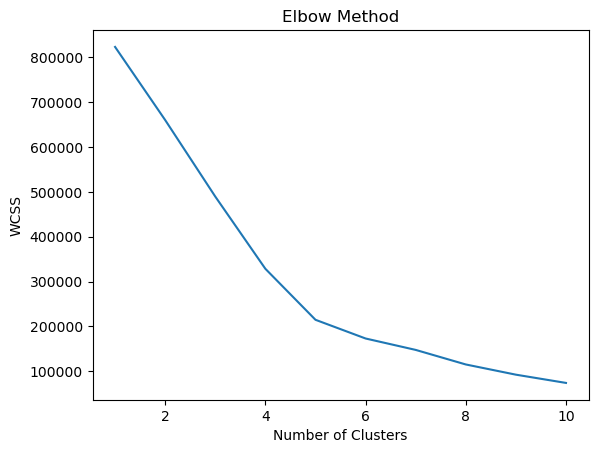

In [12]:
# Elbow method for determining the number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [13]:
# Apply K-means clustering with the optimal number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# View the cluster assignment
print(df['Cluster'].value_counts())


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
0    204501
1      1340
2         2
Name: count, dtype: int64
